In [1]:
%matplotlib inline
import pandas as pd
import ggplot as gg
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.preprocessing import scale,StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA

from scoring import calc_score
from preprocess_data import pkl_to_df,extract_df,linearsvc_outlier_rm,FeatureSel

## Exploratory data analysis
Load the data from pkl file and convert it to a pandas dataframe:

In [2]:
df=pkl_to_df()

The rows and columns of data

In [3]:
df.shape

(145, 21)

Names of columns

In [4]:
df.columns

Index(['bonus', 'deferral_payments', 'deferred_income', 'director_fees',
       'email_address', 'exercised_stock_options', 'expenses', 'from_messages',
       'from_poi_to_this_person', 'from_this_person_to_poi', 'loan_advances',
       'long_term_incentive', 'other', 'poi', 'restricted_stock',
       'restricted_stock_deferred', 'salary', 'shared_receipt_with_poi',
       'to_messages', 'total_payments', 'total_stock_value'],
      dtype='object')

In [5]:
df["poi"].astype("bool").describe()

count          145
mean     0.1241379
std      0.3308818
min          False
25%              0
50%              0
75%              0
max           True
Name: poi, dtype: object

In [6]:
ndf=df.convert_objects(convert_numeric=True)

In [7]:
ndf.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
bonus,81,1201773,1441679,70000,425000,750000,1200000,8000000
deferral_payments,38,841602.5,1289323,-102500,79644.5,221063.5,867211.2,6426990
deferred_income,48,-581049.8,942076.4,-3504386,-611209.2,-151927,-37926,-833
director_fees,16,89822.88,41112.7,3285,83674.5,106164.5,112815,137864
exercised_stock_options,101,2959559,5499450,3285,506765,1297049,2542813,3.434838e+07
expenses,94,54192.01,46108.38,148,22479,46547.5,78408.5,228763
from_messages,86,608.7907,1841.034,12,22.75,41,145.5,14368
from_poi_to_this_person,86,64.89535,86.97924,0,10,35,72.25,528
from_this_person_to_poi,86,41.23256,100.0731,0,1,8,24.75,609
loan_advances,3,2.7975e+07,4.638256e+07,400000,1200000,2000000,4.17625e+07,8.1525e+07


Only three guys have meaningful ```loan_advance``` values, let's see if it correlates to ```pio```

In [8]:
ndf.loc[np.isnan(ndf["loan_advances"])==False,"poi"]

FREVERT MARK A      False
LAY KENNETH L        True
PICKERING MARK R    False
Name: poi, dtype: bool

It seems that ```loan_advances``` is not an important feature

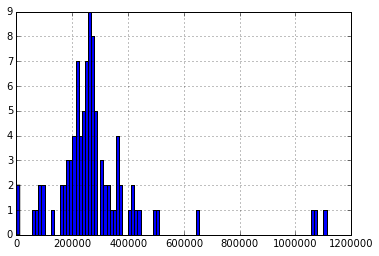

In [9]:
ndf["salary"].hist(bins=100)

In [10]:
ndf.loc[ndf["salary"]>1000000,"poi"]

FREVERT MARK A        False
LAY KENNETH L          True
SKILLING JEFFREY K     True
Name: poi, dtype: bool

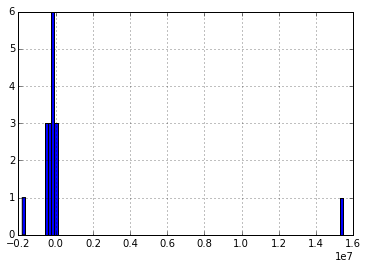

In [11]:
ndf["restricted_stock_deferred"].hist(bins=100)

In [12]:
ndf.loc[ndf["restricted_stock_deferred"]>1e7,"poi"]

BHATNAGAR SANJAY    False
Name: poi, dtype: bool

Investigate ```director_fees```

In [13]:
ndf.loc[np.isnan(ndf["director_fees"])==False,"poi"]

BELFER ROBERT              False
BHATNAGAR SANJAY           False
BLAKE JR. NORMAN P         False
CHAN RONNIE                False
DUNCAN JOHN H              False
GRAMM WENDY L              False
JAEDICKE ROBERT            False
LEMAISTRE CHARLES          False
MENDELSOHN JOHN            False
MEYER JEROME J             False
PEREIRA PAULO V. FERRAZ    False
POWERS WILLIAM             False
SAVAGE FRANK               False
URQUHART JOHN A            False
WAKEHAM JOHN               False
WINOKUR JR. HERBERT S      False
Name: poi, dtype: bool

It looks like maybe whether ```director_fees``` is NaN is a feature.
Add this new feature into the original dataset

In [14]:
df["director_fees"]=np.isnan(ndf["director_fees"])

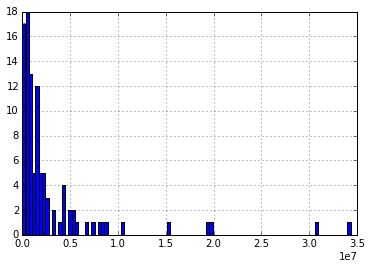

In [15]:
f="exercised_stock_options"
ndf[f].hist(bins=100)

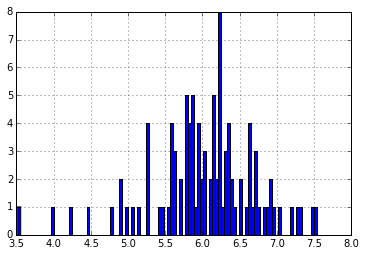

In [16]:
np.log10(ndf[f]).hist(bins=100)

Take the logrithm of this feature since the logarithm seems to be better distributed

In [17]:
df[f]=np.log10(ndf[f])

Investigate the feature ```other```

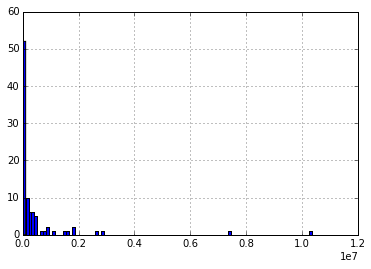

In [18]:
ndf["other"].hist(bins=100)

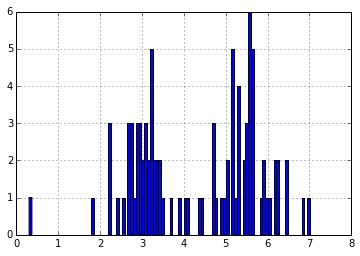

In [19]:
np.log10(ndf["other"]).hist(bins=100)

In [20]:
df["other"]=np.log10(ndf["other"])

In [21]:
nndf=ndf.drop(["poi","email_address"],axis=1)
for i in range(145):
    ar=nndf.iloc[i,:]
    if np.all(np.isnan(ar.values)):
        print(ndf.iloc[i,:])

bonus                          NaN
deferral_payments              NaN
deferred_income                NaN
director_fees                  NaN
email_address                  NaN
exercised_stock_options        NaN
expenses                       NaN
from_messages                  NaN
from_poi_to_this_person        NaN
from_this_person_to_poi        NaN
loan_advances                  NaN
long_term_incentive            NaN
other                          NaN
poi                          False
restricted_stock               NaN
restricted_stock_deferred      NaN
salary                         NaN
shared_receipt_with_poi        NaN
to_messages                    NaN
total_payments                 NaN
total_stock_value              NaN
Name: LOCKHART EUGENE E, dtype: object


In [22]:
df=df.drop("LOCKHART EUGENE E",axis=0)

### Preprocess the data

Convert the dataframe to a matrix

In [23]:
X,y=extract_df(df,["email_address","poi","loan_advances","restricted_stock_deferred","deferral_payments"])
#X,y=extract_df(df,["email_address","poi"])

Index(['bonus', 'deferred_income', 'director_fees', 'exercised_stock_options',
       'expenses', 'from_messages', 'from_poi_to_this_person',
       'from_this_person_to_poi', 'long_term_incentive', 'other',
       'restricted_stock', 'salary', 'shared_receipt_with_poi', 'to_messages',
       'total_payments', 'total_stock_value'],
      dtype='object')


In [24]:
imp=Imputer(axis=0,strategy="median")
n_X=imp.fit_transform(X)

### Run a Linear SVC model without removing any outliers or feature selection

In [25]:
#set up a LinearSVC model
sd=StandardScaler()
lvc=LinearSVC(C=0.1)
svcpp=Pipeline([("sd",sd),("lvc",lvc)])
calc_score(n_X,y,svcpp)

precision: 0.32808988764044944
recall: 0.073
f1: 0.11942740286298568


### Run a navie bayes algorithm and test the results

In [26]:
calc_score(n_X,y,GaussianNB())

precision: 0.18813314037626627
recall: 0.52
f1: 0.2763018065887354


### Run a random forest classification

In [27]:
calc_score(n_X,y,RandomForestClassifier())

precision: 0.31762917933130697
recall: 0.1045
f1: 0.15726109857035364


### Run Gradient Boosting Machine

In [28]:
calc_score(n_X,y,GradientBoostingClassifier())

precision: 0.30054151624548736
recall: 0.1665
f1: 0.21428571428571427


### Outlier removal using LinearSVC

In [29]:
f_X,f_y,dis_y=linearsvc_outlier_rm(n_X,y,discard=0.2,lvc_C=0.1)

(array([   1.,    0.,    0.,    0.,    1.,    3.,  109.,   21.,    4.,    5.]),
 array([-3.87664737, -3.41293684, -2.94922631, -2.48551577, -2.02180524,
        -1.55809471, -1.09438418, -0.63067365, -0.16696312,  0.29674741,
         0.76045794]),
 <a list of 10 Patch objects>)

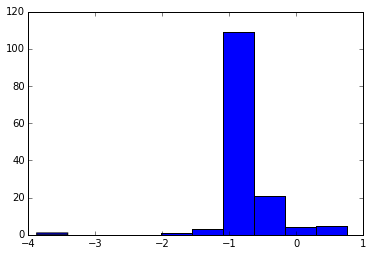

In [30]:
plt.hist(dis_y)

#### Test a few classification algorithms again

In [31]:
#set up a LinearSVC model
sd=StandardScaler()
lvc=LinearSVC(C=0.1)
svcpp=Pipeline([("sd",sd),("lvc",lvc)])
calc_score(f_X,f_y,svcpp)

precision: 0.3641732283464567
recall: 0.0925
f1: 0.14752791068580542


In [32]:
calc_score(f_X,f_y,GaussianNB())

precision: 0.22498676548438326
recall: 0.425
f1: 0.2942194530979578


In [33]:
calc_score(f_X,f_y,RandomForestClassifier())

precision: 0.2931726907630522
recall: 0.1095
f1: 0.15944666909355662


In [34]:
calc_score(f_X,f_y,GradientBoostingClassifier())

precision: 0.3210568454763811
recall: 0.2005
f1: 0.24684518313327178


Both recall and precision increase slightly after removing outliers

### Feature selection
Use SelectKBest algorithm to select import features

In [35]:
skb=SelectKBest(k=16)

In [36]:
sd=StandardScaler()
lvc=LinearSVC(C=0.1)
svcpp=Pipeline([("sd",sd),("skb",skb),("lvc",lvc)])
calc_score(f_X,f_y,svcpp)

precision: 0.3060796645702306
recall: 0.073
f1: 0.11788453774727493


User PCA to select features

In [37]:
pca=PCA(n_components=10,whiten=True)

### Test some classifiers

In [38]:
lvc=LinearSVC(C=0.0001,tol=0.0001)
svcpp=Pipeline([("skb",skb),("pca",pca),("sd",sd),("lvc",lvc)])
calc_score(f_X,f_y,svcpp)

precision: 0.33986928104575165
recall: 0.104
f1: 0.15926493108728942


In [39]:
lvc=LinearSVC(C=10,tol=1e-1)
svcpp=Pipeline([("pca",pca),("lvc",lvc)])
calc_score(f_X,f_y,svcpp)

precision: 0.42525399129172714
recall: 0.1465
f1: 0.21792487913722575


In [40]:
rf=RandomForestClassifier()
svcpp=Pipeline([("skb",skb),("pca",pca),("rf",rf)])
calc_score(f_X,f_y,svcpp)

precision: 0.33962264150943394
recall: 0.135
f1: 0.19320214669051877


### Best result

In [41]:
svcpp=Pipeline([("skb",skb),("pca",pca),("rf",GaussianNB())])
calc_score(f_X,f_y,svcpp)

precision: 0.3808674985145573
recall: 0.3205
f1: 0.3480857996198751


In [42]:
svcpp=Pipeline([("skb",skb),("pca",pca),("rf",LogisticRegression())])
calc_score(f_X,f_y,svcpp)

precision: 0.30440967283072545
recall: 0.107
f1: 0.15834258231594525


Put SelectKBest and PCA in the pipeline drastically improves precision, recall and f1 scores further.

Previous algorithms removes outlier first and then run feature selections. In this test, we perform outlier removal after feature selection.

In [43]:
#feature selection
fsel=Pipeline([("skb",skb),("pca",pca)])
fn_X=fsel.fit_transform(n_X,y)
fn_X,fn_y,_=linearsvc_outlier_rm(fn_X,y)
fn_X=scale(fn_X)
calc_score(fn_X,fn_y,lvc)

precision: 0.4617524339360223
recall: 0.166
f1: 0.24420742920191246


### Best availabe result
Use feature selection, without outlier removal using LinearSVC. Just remove data entries *TOTAL* and another one with all NaN. Then combine PCA components and SelectKBest

In [44]:
fsl=FeatureSel(k_best=10,pca_comp=10)
ppl=Pipeline([("fsl",fsl),("sd",sd),("lvc",LinearSVC(C=0.000001,tol=0.0000001))])
calc_score(n_X,y,ppl)

precision: 0.3970315398886827
recall: 0.428
f1: 0.41193455245428295


Other reults that uses ```FeatureSel()``` class

In [45]:
fsl=FeatureSel(k_best=10,pca_comp=10)
ppl=Pipeline([("fsl",fsl),("sd",sd),("lvc",LinearSVC(C=0.000001,tol=0.000001))])
calc_score(f_X,f_y,ppl)

precision: 0.30484627410109433
recall: 0.2925
f1: 0.29854554733350347


In [46]:
fsl=FeatureSel(k_best=10,pca_comp=10)
ppl=Pipeline([("fsl",fsl),("sd",sd),("lvc",LinearSVC(C=0.0001,tol=0.01))])
calc_score(f_X,f_y,ppl)

precision: 0.3211920529801324
recall: 0.291
f1: 0.30535152151101785


In [47]:
ppl=Pipeline([("fsl",fsl),("sd",sd),("lvc",RandomForestClassifier(n_estimators=10,max_features=5))])
calc_score(f_X,f_y,ppl)

precision: 0.26657824933687
recall: 0.1005
f1: 0.14596949891067537


In [48]:
ppl=Pipeline([("fsl",fsl),("sd",sd),("lvc",GaussianNB())])
calc_score(f_X,f_y,ppl)

precision: 0.3428892636312535
recall: 0.305
f1: 0.32283672929346385


In [49]:
ppl=Pipeline([("fsl",fsl),("sd",sd),("lvc",GradientBoostingClassifier())])
calc_score(f_X,f_y,ppl)

precision: 0.21592539454806312
recall: 0.1505
f1: 0.1773718326458456


In [50]:
ppl=Pipeline([("fsl",fsl),("sd",sd),("lvc",LogisticRegression())])
calc_score(f_X,f_y,ppl)

precision: 0.31758957654723124
recall: 0.0975
f1: 0.14919663351185922


In [51]:
from sklearn.svm import SVC
ppl=Pipeline([("fsl",fsl),("sd",sd),("lvc",SVC(C=10))])
calc_score(n_X,y,ppl)

precision: 0.1016949152542373
recall: 0.033
f1: 0.04983012457531144


In [52]:
from sklearn.ensemble import AdaBoostClassifier
ppl=Pipeline([("fsl",fsl),("sd",sd),("lvc",AdaBoostClassifier())])
calc_score(f_X,f_y,ppl)

precision: 0.1757259865971705
recall: 0.118
f1: 0.14119054741250375
